# Atividade 1 - Regressão Linear


## Introdução

<font size=4.25>

<p style='text-align: justify;'>
Os modelos de regressão linear, apesar de simples, são suficientemente poderosos para a resolução de alguns problemas. Nesta atividade vamos explorá-lo, elaborando-o do zero (<em> from scratch </em>). Para tal, utilizaremos a série histórica de medidas do número de manchas solares observadas pelo <em> Atacama Large Milimiter/SubMilimiter Array </em> (ALMA). A abordagem do modelo de regressão linear deu-se através de dois modos: com e sem a utilização do termo de regularização. Salienta-se que ao utilizar o termo de regularização, os dados foram submetidos previamente a uma tranformação não linear em uma estrutura semelhante a uma <em> Extreme Machine Learning </em> (ELM). Dito isso, esta atividade compreenderá as seguintes etapas:
</p>
    
1.<b>Tratamento prévio</b>
    
- Definição de funções importantes
    
- Divisão dos dados - Treinamento e Teste
    
2.<b> Regressão Linear</b> 
    
- Modelagem Matemática
    
- Determinação do Hiperparâmetro K
    
- Determinação do vetor de parâmetros w e comparativo com os dados de teste

3.<b> Regressão Linear com Regularização (<em>Ridge Regression</em>)<br>

- Modelagem Matemática
    
- Tratamento e Preparação dos Dados
    
- Estimativa de T e do parâmetro de regularização
    
- Determinação  do vetor de parâmetros w e comparativo com os dados de teste

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from numpy.random import uniform
import os
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('monthly-sunspots.csv', sep=";")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3252 non-null   int64  
 1   Date                               3252 non-null   object 
 2   Monthly Mean Total Sunspot Number  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB


## 1. Tratamento Prévio 

### 1.1 Definindo funções importantes

<font size=4.25>

<p style='text-align: justify;'>
Neste etapa do trabalho, criou-se duas funções: uma que tem por obejtivo o tratamento das datas no banco de dados, a fim de padronizá-las e torná-las do tipo DateTime, e a outra para a plotar o gráfico com os dados do problema.
</p>


In [2]:
def replace_data (x):
    
    if '/' in x:
    
        new_data = ''

        lista_char =x.split('/')

        new_data = lista_char[2]+'-'+lista_char[1]+'-'+lista_char[0]

        return new_data
    
    else: 
        
        return x

    
df['Date'] = df['Date'].apply(replace_data)

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


def plot_graph(df, split_train_teste=False):

    plt.figure(figsize=(15,8))

    plt.plot(df['Date'], df['Monthly Mean Total Sunspot Number'])

    plt.xlabel('Time - Monthly', fontsize=12)

    plt.ylabel ('Monthly Mean Total Sunspot Number', fontsize=12)
    
    if split_train_teste:
        
        period=int(input('Qual é o período referente ao conjunto de testes (em meses):'))
        
        plt.axvline(x=df['Date'].max()-pd.DateOffset(months=period), color='r')
        
    plt.show()
    

### 1.2 Dividindo os dados - Treinamento e Teste

<font size=4.5>
<p style='text-align: justify;'>
Os dados utilizados foram divididos em duas partes, o conjunto de treinamento e o conjunto de teste. O conjunto de treinamento (denominado como <b>y_training_data</b>) compreende os dados observadors entre 1749 e 2009, enquanto o conjunto de testes é composto dos dados observados entre 2010 e 2019 (denominado como <b>y_test</b>). A linha vermelha no gráfico abaixo  ilustra a divisão enre os dados de treinamento e os dados de teste. 
</p>

Qual é o período referente ao conjunto de testes (em meses):120


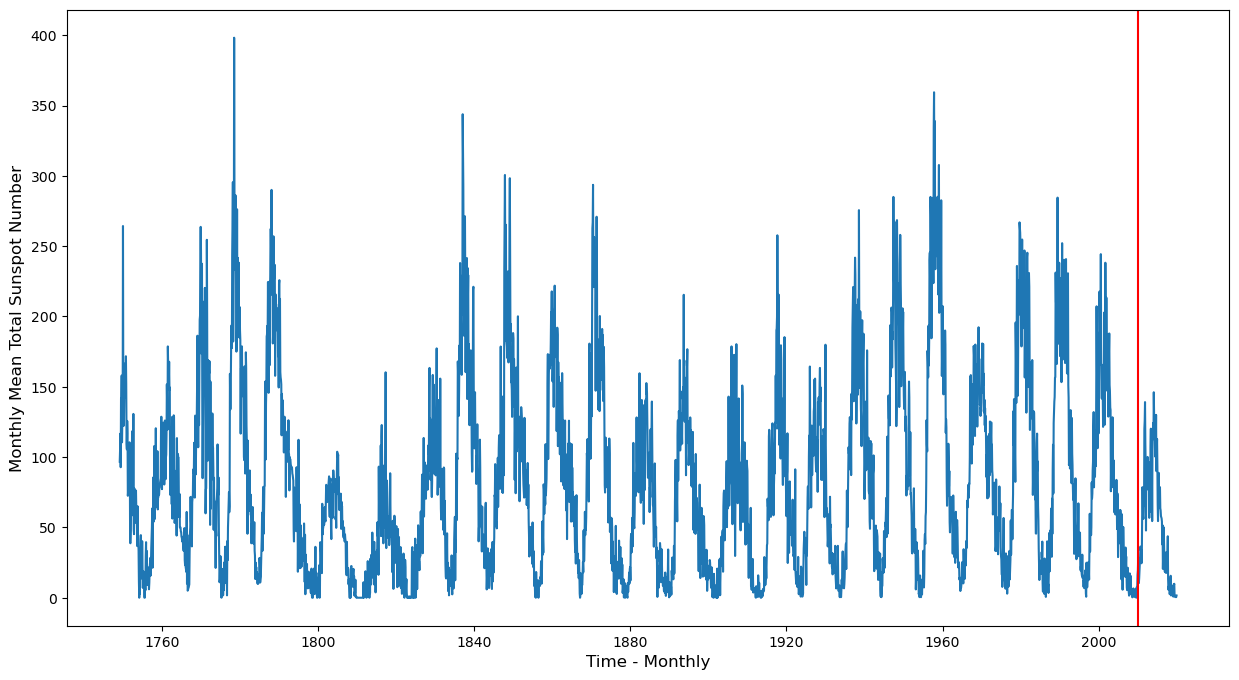

In [3]:
total_data_set = df.iloc[0:len(df),2].to_numpy()

y_training_data = df.iloc[0:len(df)-120,2].to_numpy()

y_test = df.iloc[(len(df)-120):,2].to_numpy()

plot_graph(df, split_train_teste=True)

## 2 - Regressão Linear 

### 2.1 Modelagem Matemática <br>

<font size=4>

<p style='text-align: justify;'>
A definição do modelo matemático pode ser realizada através da solução de um problema de quadrados mínimos lineares. Fundamentalmente este tipo de problema tem como objetivo aproximar soluções de sistemas de equações lineares sobredeterminados, isto é, sistemas que apresentam mais equações do que variáveis. Esta abordagem normalmente é feita minimizando-se o quadrados dos erros em cada uma das equações. Matematicamente, o sistema linear sobredeterminado pode ser definido pela Equação 1.     
</p>
  
\begin{equation} 
{A}{w} = Y 
\end{equation} 

<p style='text-align: justify;'> 
Em que A ϵ $R^{N X K}$ são os dados, com N>K ou geralmente N >>K. Naturalmente assume-se que o sistema é incompatível e, portanto, deve-se definir um vetor <em> w </em> em que o resíduo do sistema, definido pela Equação 2, seja o menor possível.    
</p>
            
    
\begin{equation} 
{r(x)} = {Y}-Aw 
\end{equation} 
    
        
Assim sendo, a função objetivo do problema de quadrados mínimos consiste na minimização da norma euclidiana do resíduo do sistema, conforme demonstra a Equação 3.
    
\begin{equation} 
min{f_o(x)} =  \| Aw-y\|_{2}^{2} = \|r(x)\|_{2}^{2} = \sum_{i=1}^{m} r_{i}^{2}
\end{equation}
    
Onde $r_{i}$ é a i-ésima componente de r.  
    
    
Dado a configuração da equação de resíduos, a minimização da mesma indicará quais valores de w aproximam os valores de entrada com os de saída. 
    


In [4]:
def mean_squared_error (Y_data,y_hat):
    e2=np.square(y_hat-Y_data)
    MSE = (1/(len(Y_data)))*np.sum(e2)
    
    return MSE

<font size=4.5>

<p style='text-align: justify;'>    
O modelo matemático de estimação para realizar o mapeamento da equação de resíduos, previamente exposta, é definido pela Equação 4.
</p>   
    
\begin{equation} 
\hat{Y}(x) = Ф(x)^{T}w
\end{equation}
    
Em que Ф(x) ϵ $R^{NXK+1}$. 
    
<font size=4.5>

<p style='text-align: justify;'>    
A matriz e o vetor abaixo referem-se, respectivamente, aos dados das sequências temporais X(n), somado de uma entrada fixa de valor unitário que está relacionado a ${w_{o}}$, bem como ao vetor de parâmetros w (o qual será ajustado através do aprendizado do modelo).
</p>
    
$$ Ф(x)^{T} =
\left [
\begin{matrix}
1 & X(n-1) & X(n-2) & X(n-3) & \cdots  & X(n-K)\\
1 & X(n) & X(n-1) & X(n-2) & \cdots  & X(n-K+1) \\
1 & X(n+1) & X(n) & X(n-1) & \cdots  & X(n-K+2) \\
1 & X(n+2) & X(n+1) & X(n) & \cdots & X(n-K+3) \\
1 & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & X(N) & \cdots & \cdots & \cdots & X(N-K) \\
\end{matrix}
\right ] 
$$

$$ w =
\left [
\begin{matrix}
{w}_0 \\
{w}_1  \\
{w}_2  \\
\vdots \\
\vdots \\
{w}_K \\
\end{matrix}
\right ] 
$$
  

<p style='text-align: justify;'>    
Da configuração previamente citada, x(n) (correspondente a cada linha da matriz  Ф(x)) é o valor da série temporal no instante (discreto) n e o modelo construído deve reallizar um mapeamento do vetor entradas x(n) ϵ $R^{K X 1}$, o qual é formado por um subconjunto de K amostras passadas para uma saída <em >ŷ(n) </em>, que representa uma estimativa do valor futuro da série $x(n)^*$.    
</p>
   
<p style='text-align: justify;'>
No contexto previamente exposto, K é definido como um hiperparâmetro do modelo. Isto é, quantos valores K passados são necessários utilizar para que o previsto (K+1) seja o mais próximo do real. 
</p>

<p style='text-align: justify;'>
A determinação do valor de K foi definida a partir um processo de validação cruzada do tipo <em> k-fold </em>. A validação cruzada consiste, a partir do conjunto de treinamento, na separação dos dados em um conjunto de treinamento - necessário à determinação dos parâmetros <em>w</em> - e um conjunto de validação. A partir deste, pode-se estimar a capacidade de generalização do modelo, ou seja, está atrelado à qualidade de aproximação produzida pelo modelo quando exposto a dados de entrada não vistos durante o treinamento.
</p>
   
<p style='text-align: justify;'>
O método de <em>k-fold</em>, conforme demonstra a figura abaixo, consiste em dividir o conjunto de amostras disponíveis para treinamento em k pastas e realizar k treinamentos, cada um considerando k-1 pastas para o ajuste dos parâmetros e 1 pasta para validação.  
</p>
    
<img src="k-fold-ajustado.png">
    
    
A função a seguir apresenta o processo de validação cruzada k-fold para o problema apresentado.

In [5]:
def create_kfold (k,initial_X_train,initial_Y_train,i):
    
    len_X_training = len(initial_X_train)
    n= len_X_training/k
    training_indices = np.arange(0, len_X_training)
    if i ==0:
            validation_indices = np.arange(0,n)
    else:
            validation_indices = np.arange(i*n,(i+1)*n)
                            
    validation_indices=validation_indices.astype(int)
    train_indices = np.delete(training_indices, validation_indices)
                    
    X_train = initial_X_train[train_indices]
    Y_train = initial_Y_train[train_indices]
                    
    X_validation = initial_X_train[validation_indices]
    Y_validation = initial_Y_train[validation_indices]
    
    return X_train, Y_train, X_validation, Y_validation


<font size=4.5>

<p style='text-align: justify;'>    
Por fim, é necessário determinar o processo de aprendizado, isto é, de qual forma os pesos w serão determinados. Tal como explicitado anteriormente, o sistema de equações é sobredeterminado (mais equações do que variáveis), podendo portanto ser utilizado uma equação analítica (solução fechada) para a determinação dos pesos/parâmetros (<em>w</em>), conhecida como equação normal (Equação 5):
</p>

    
\begin{equation} 
{w} = ({Ф^{T}Ф})^{-1}Ф^{T}*y
\end{equation} 

In [6]:
def normal_equation (X_train, Y_train, param_reg):
    I_line = np.eye(X_train.shape[1])
    I_line[0,0]=0    
    X_trans = X_train.T
    reg_term = param_reg*I_line
    w=np.dot(inv(np.dot(X_trans, X_train)+reg_term), np.dot(X_trans, Y_train))
     
    return w

<font size=4.5>

<p style='text-align: justify;'>    
Antes da determinação do hiperparâmetro K bem como dos parâmetros necessários à minimização da função objetivo, é necessário definir uma função que adeque as matriz de entrada e o vetor saída de acordo com o número de atrasos K.
</p>

In [7]:
def create_input_data (initial_train_data_set, K):
    train_data_size=len(initial_train_data_set)
    initial_X_train=np.zeros((train_data_size-K, K))
    initial_Y_train=np.zeros(train_data_size-K)
    
    for i in range(train_data_size-K):
        for j in range(K):
            initial_X_train[i, j] = initial_train_data_set[i+K-j-1]
            initial_Y_train[i] = initial_train_data_set[i+K]

    return initial_X_train, initial_Y_train


### 2.2 Determinação do Hiperparâmetro K <br>


<font size=4.5>

<p style='text-align: justify;'>
O valor de K foi testado até 24. A partir de cada valor K, eram formados os diferentes conjuntos de validação e treinamento, com 4 composições distintas para cada valor de K, e o RMSE médio (Erro Quadrático Médio - Equação de Resíduos) era levantado. Da Figura abaixo, nota-se que o valor K que resultou no menor RMSE foi equivalente a 24.     
</p>

Text(0, 0.5, 'RMSE - Erro Quadrático Médio')

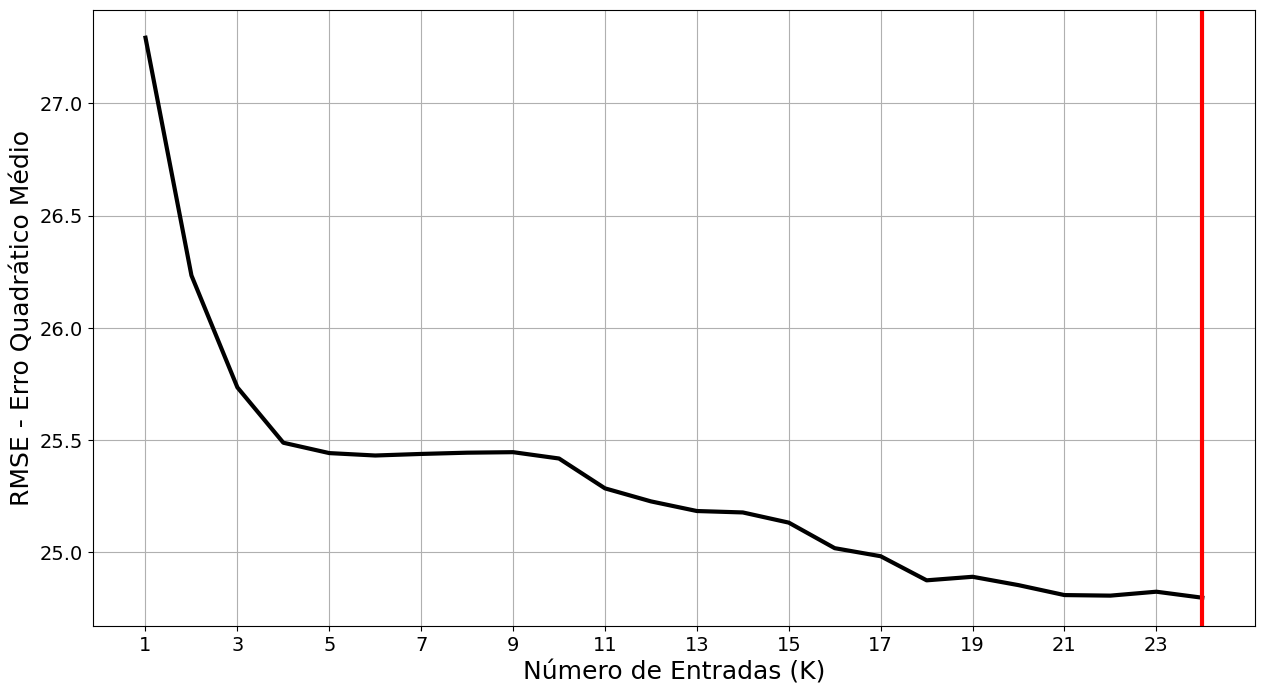

In [8]:
k=4
lista_RMSE=[]
lista_K = [x for x in range(1,25)]
for K in lista_K:
    lista=[]
    initial_X_train, initial_Y_train = create_input_data (y_training_data, K)
    for i in range (k):
       X_train, Y_train, X_validation, Y_validation = create_kfold(k,initial_X_train,initial_Y_train,i)
        
       X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
       X_validation = np.concatenate((np.ones((len(X_validation), 1)), X_validation), axis=1)
     
       X_trans = X_train.T
       w = normal_equation(X_train, Y_train,0)
          
       y_hat = np.dot(X_validation,w)       
       MSE = mean_squared_error(Y_validation, y_hat)
   
       lista.append(MSE)
    lista_RMSE.append((np.sum(lista)/k)**0.5)

plt.figure(figsize=(15,8))
plt.plot(lista_K, lista_RMSE ,color="black", linewidth=3)
plt.xticks([x for x in range(1,25,2)],fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(np.argmin(np.array(lista_RMSE))+1, color='red', linewidth=3)
plt.grid()
plt.xlabel("Número de Entradas (K)", fontsize=18)
plt.ylabel("RMSE - Erro Quadrático Médio",fontsize=18)


### 2.3 Determinando o vetor de parâmetros <em> w </em> e comparativo com os dados de Teste <br>


<font size=4.5>

<p style='text-align: justify;'>
    Com o hiperparâmetro K determinado, é possível obter o vetor de parâmetros <em> w </em> que haverá a minimização da equação de resíduos (função objetivo do problema de mínimos quadrados). Para tal, é necessário determinar o vetor de pesos/parâmetros <em>w</em>,a partir da equação normal (Equação 5), junto a todo o conjunto de treinamento (treinamento + validação). 

<p style='text-align: justify;'>
Conforme ilustra a figura abaixo, os valores preditos pelo modelo obtido são semelhantes aos dados de teste, compeendendo uma parcela considerável das sazonlidades presentes no cojuntos de dados avaliados.
</p>

Text(0, 0.5, 'Número Médio de Manchas Solares')

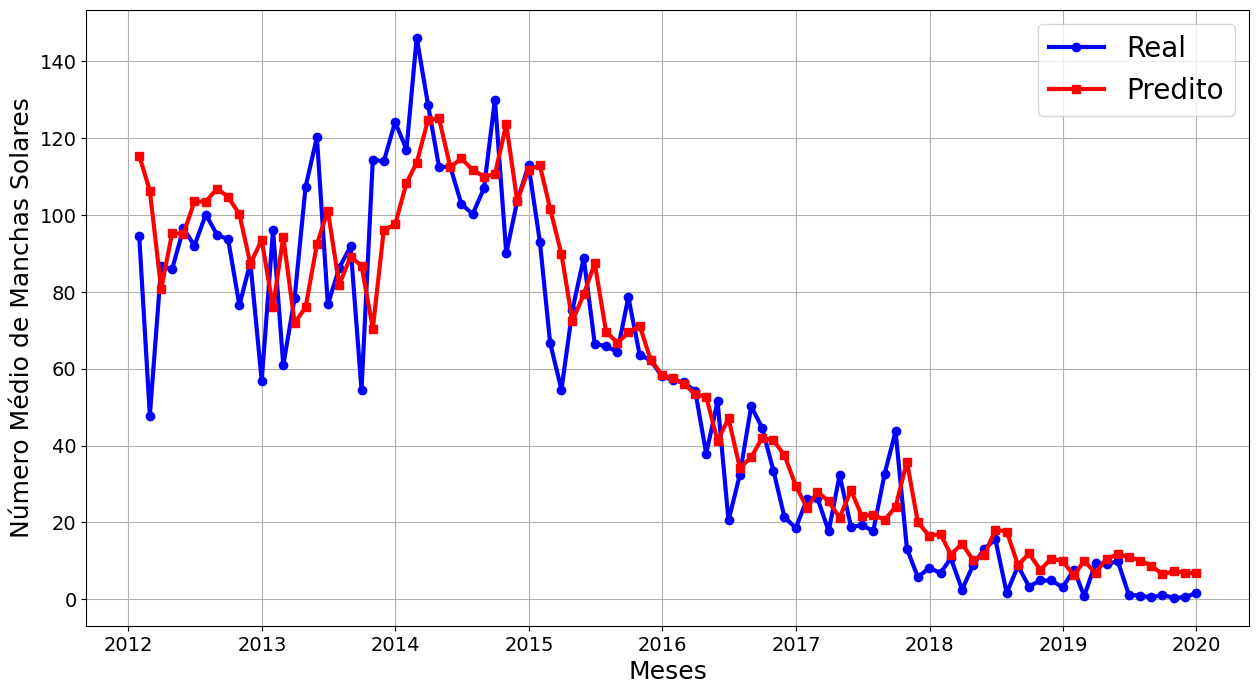

In [9]:
K_min = np.argmin(lista_RMSE)+1

X_train_final, Y_train_final = create_input_data (y_training_data, K_min)
vetor_bias=np.ones((len(X_train_final),1))
X_train_final = np.concatenate((vetor_bias, X_train_final), axis=1)

X_train_final_trans = X_train_final.T

w_teste = normal_equation(X_train_final, Y_train_final,0)

X_teste, Y_teste = create_input_data (y_test, K_min)
vetor_bias=np.ones((len(X_teste),1))
X_teste = np.concatenate((vetor_bias, X_teste), axis=1) 

y_hat_teste=np.dot(X_teste,w_teste)

new_df = df[df['Date']>=df['Date'].max()-pd.DateOffset(months=120-K_min-1)]

plt.figure(figsize=(15,8))
plt.plot(new_df['Date'],Y_teste ,color="blue", label="Real", linewidth=3, marker="o")
plt.plot(new_df['Date'],y_hat_teste, color="red", label="Predito", linewidth=3, marker="s")
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel("Meses", fontsize=18)
plt.ylabel("Número Médio de Manchas Solares",fontsize=18)

## 3 - Regressão Linear com Regularização (Ridge Regression)

    
### 3.1 Modelagem Matemática <br>
  

<font size=4.5>

<p style='text-align: justify;'>
Nesta parte da atividade avaliou-se o comportameno do modelo matemático de estimação a partir da adição de um termo de regularização. Assim, a equação de resíduos (função objetivo do problema), previamente exposta, adquire um configuração equivalente a da Equação 6. 
</p>   
    
\begin{equation} 
min f_{0}(x) = \| Aw-y\|_{2}^{2} + λ\|w\|_{2}^{2}
\end{equation}
 
<font size=4.5>    
    
<p style='text-align: justify;'>
Conforme pode ser visto na equação acima, houve a introdução de um termo de penalização proporcional à norma euclidiana do vetor de parâmetros/pesos (<em>w</em>). Com isso, em vez de minimizar a somente o erro quadrático, minimiza-se a soma entre o erro quadrático e a norma euclidiana do vetor de parâmetros.
</p> 
    
<p style='text-align: justify;'>
A utilização da regularização tem como objetivo a redução da possibilidade de ocorrência de sobre ajuste (<em>overfitting</em>), melhorando assim a capacidade de generalização do modelo e, portanto, o seu desempenho efetivo. A introdução do termo de regularizção é uma forma impedir que a a diferença entre os valoes preditos e reais alcancem o seu menor valor possível. Conforme apresenta a figura abaixo, o algoritmo irá encontrar um ponto de equilíbrio entre a equação de resíduos ($ \| Aw-y\|_{2}^{2}$) e o termo de penalidade ($\|w\|_{2}^{2}$).
</p>   
    
<img src="regularization.png">
         
<p style='text-align: justify;'>
    Conforme pode ser visto na Equação 7, a definição dos valores que compõem o vetor <em> w </em> (pesos) para este caso também pode se dar através de uma solução fehada, semelhante àquela obtida para o caso sem a adição do termo de regularização. 
</p>  

    
\begin{equation} 
w = (Ф^{T}Ф + λI')^{-1}Ф^{T}y
\end{equation}

    
onde: $$ I' =
\left [
\begin{matrix}
0 & 0 & \cdots & 0\\
0 & 1 &  \cdots & 0 \\
\vdots & \vdots  & \ddots & 0 \\
0 & \vdots & \vdots &  1\\
\end{matrix}
\right ] 
$$

Ressalta-se que embora a matriz Ф não possua posto completo, a inversa sempre exisitirá por conta da adição do termo de regularização à diagonal principal.
        
<font size=4.5>
<p style='text-align: justify;'>
Além da regularização como fator novo nesta etapa da modelagem, o modelo de predição linear é alimentado por valores de entrada obtidos a partir de tranformações não lineares do vetor X(n). Isto é, os atributos que são efetivamente combinados linearmente são produtos de mapeamentos não lineares dos atrasos das séries presentes no vetor original X(n). Assim, gerou-se T atributos transformados conforme a Equação 8:   
</p>   

\begin{equation} 
X'_{k}(n) = tanh(\beta_{k}^{T}x(n))
\end{equation} 

<p style='text-align: justify;'>
para  k=1,...,T, n=1,...,N. Os vetores $\beta_{k}$ tem seus elementos gerados aleatoriamente de acordo com uma distribuição uniforme. Desta forma, o modelo de estimação irá adquirir uma configuração semelhante à Equação 9:
</p> 
              
\begin{equation} 
\hat{Y}(x) = X'_{k}(n)w_{T} = tanh(\beta_{k}^{T}x(n))*w_{T}
\end{equation}
        
<p style='text-align: justify;'>
Embora as entradas do modelo são resultados de transformações não lineares, a solução fechada para a determinação dos parâmetros w continua sendo válida uma vez que a linearidade está sendo preservada entre os parâmetros/pesos (<em>w</em>) do modelo proposto. Além disso, a estrutura explorada para a modelagem desta parte do exercício é correspondente a uma rede neural conhecida como <em> extreme machine learning </em> (ELM).
</p>     
   

### 3.2 Tratamento  e Preparação dos Dados <br>

<font size=4.5>

<p style='text-align: justify;'>
Antes de realizar as transformações lineares propriamente ditas, as seguintes premissas foram levadas em conta:
</p>
    
    
- Normalização dos dados: Tem-se a necessidade disto a fim de que o conjunto de dados, quando combinados linearmente com os parâmetros do modelo (peso), não sejam compostos essencialmente de valores saturados (0 ou 1).

- Delimitação dos valores de $\beta_{k}\$: Tais  valores foram delimitados entre 0 e 0.3 a fim também de não promover as saturações dos dados.     

<font size=4.5>    
<p style='text-align: justify;'>
Conforme pode ser visto na Figura abaixo, a função tangente hiperbólico apresenta saturações para valores acima de 2.4, assim, é necessário que os valores de $\beta_{k}$ quando combinados linearmente com os valores de X(n) não resultem em valores acima de 2.4 e que, portanto, o conjunto de dados não seja essencialmente composto por valores saturados.  
</p>

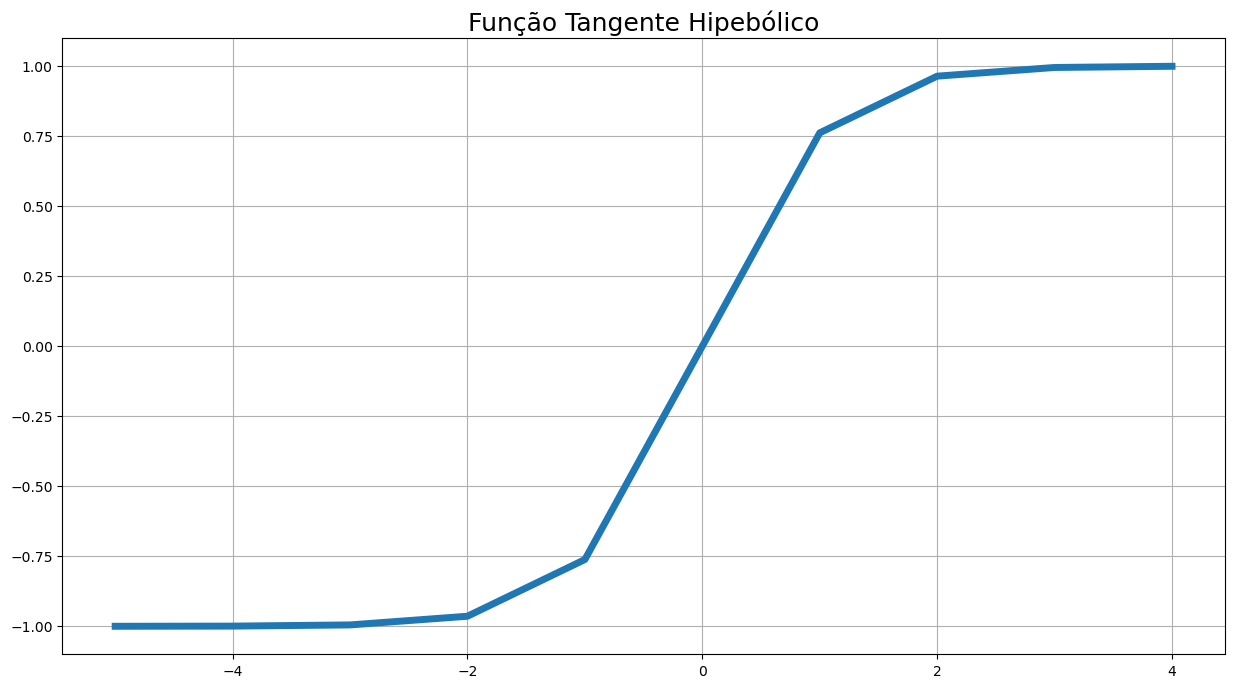

In [10]:
plt.figure(figsize=(15,8))

plt.plot([i for i in range(-5,5,1)],np.tanh([i for i in range(-5,5,1)]), linewidth=5)

plt.title ("Função Tangente Hipebólico", fontsize=18)

plt.grid()

plt.show()

<font size=4.5>

<p style='text-align: justify;'>
A transformações não lineares dos dados foi feita considerando um K=8 (número de atrasos presentes no vetor X(n)). Além disso, os dados de treinamento e teste foram divididos tal como na primeira etapa do problema. 
</p>

In [11]:
## Estabelecendo Parâmetros Iniciais
K_entrada = 8
k_fold=4
T_lim=100
n_param_reg=200

## Normalização dos dados e separação dos dados de treinamento e teste
min_data = min(total_data_set)
data_interval = max(total_data_set)-min_data
norm_data_set = (total_data_set-min_data)/data_interval
train_data_norm = norm_data_set[0:len(total_data_set)-120]
test_data_norm = norm_data_set[(len(total_data_set)-120):]
w_k = uniform(0, 0.3, size=(K_entrada, T_lim))

## Determinando 
X_train_data_norm, Y_train_data_norm = create_input_data (train_data_norm, K_entrada)
X_test_data_norm, Y_test_data_norm = create_input_data (test_data_norm, K_entrada)

#Aplicando as transformações não-lineares
final_X_train_data=np.tanh(np.dot(X_train_data_norm,w_k))
final_X_test_data =np.tanh(np.dot(X_test_data_norm,w_k))

### 3.3 Estimativa de  T e do parâmetro de regularização ($\lambda$)<br>

<font size=4.5>

<p style='text-align: justify;'>
A fim de levantar o valor de T atributos transformados (variando entre 0 e 100) que  implica no menor RMSE, aplicou-se o método de validação cruzada k-fold (tal como foi feito na primeira etapa deste exercício). Além da determinação do valor de T, é também necessário encontrar o valor do parâmetro de regularização ($\lambda$) para que a condição de minimização da função obejtivo também seja satisfeita. Assim sendo, a cada valor de T entradas do modelo eram testados valores de ($\lambda$) entre  0 e 1 com um passo equivalente a 0.005. Ressalta-se que os valores de RMSE foram levantados a partir da desnormalização dos dados, isto é, no domínio original do problema (função abaixo).
</p>

In [12]:
def inver_norm (data,min_value, interval):
    final_value=((interval)*data)+min_value
    return final_value

In [13]:
matriz_MSE_final = np.zeros((T_lim,n_param_reg))

for T in range(1,T_lim+1):
    contador=0
    X_train=final_X_train_data[:,0:T] 
    for param_reg in np.arange(0,1,0.005):
        contador+=1
        lista_MSE=[]
        
        for i in range(k_fold):
            final_X_train, final_Y_train, final_X_validation, final_Y_validation = create_kfold(k_fold,X_train,Y_train_data_norm, i)
            
            final_X_train = np.concatenate((np.ones((len(final_X_train), 1)), final_X_train), axis=1)
            final_X_validation = np.concatenate((np.ones((len(final_X_validation), 1)), final_X_validation), axis=1)
               
            w=normal_equation(final_X_train,final_Y_train, param_reg)
            
            y_hat = np.dot(final_X_validation, w)
            y_hat_desnorm = inver_norm(y_hat,min_data,data_interval)
            final_Y_validation_desnorm=inver_norm(final_Y_validation,min_data,data_interval)
            
            MSE = mean_squared_error (final_Y_validation_desnorm, y_hat_desnorm) 
            lista_MSE.append(MSE)
            
        matriz_MSE_final[T-1,contador-1]=(1/k_fold)*np.sum(lista_MSE)
        
rms_K_val = np.sqrt(matriz_MSE_final)

matriz_min=np.zeros(rms_K_val.shape[0])
for i in range (len(rms_K_val)):
    matriz_min[i]=np.min(rms_K_val[i,:]) 

<font size=4.5>

<p style='text-align: justify;'>
Após o valor de T ser testado no intervalo citado bem como para diferentes valores de $\lambda$, constatou-se que o valor de T que resultava no menor RMSE durante o processo de validação cruzada foi equivalente a 39 (linha vermelha no gráfico abaixo). Nota-se da mesma figura que os valores de RMSE são bastante similres a partir de T igual 10 (linha azul pontilhada do gráfico), indicando que a construção do modelo pode ser feita baseada em valores de T acima desse limiar sem que o desempenho do modelo seja efetivamente afetado.
</p>

Text(0, 0.5, 'RMSE')

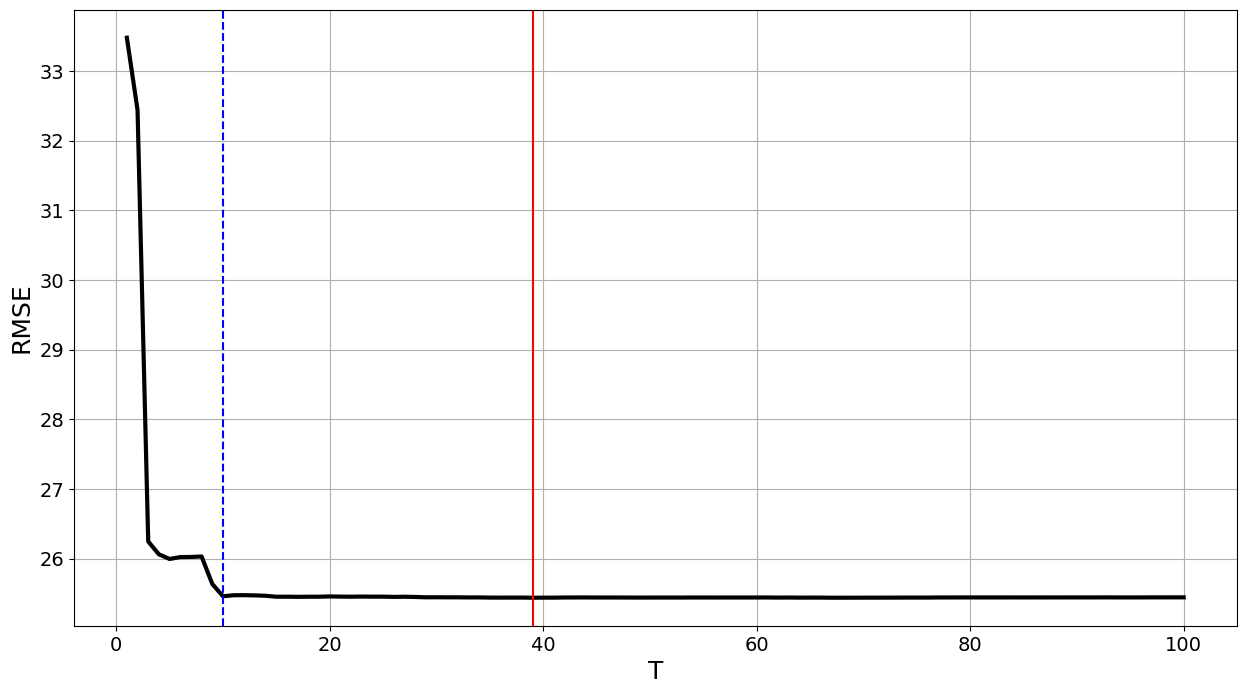

In [19]:
fig_A=plt.figure(figsize=(15,8))
plt.plot([x for x in range(1,101,1)], matriz_min ,color="black", linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(np.argmin(matriz_min)+1, color='red')
plt.axvline(10, color='blue',linestyle='dashed')
plt.grid()
plt.xlabel("T", fontsize=18)
plt.ylabel("RMSE",fontsize=18)

<font size=4.5>

<p style='text-align: justify;'>
No que diz respeito à seleção do valor de $\lambda$ (parâmetro de regularização), esta foi baseada no gráfico da Figura abaixo. Neste gráfico foram levantados os valores de $\lambda$ que resultaram nos menores RMSEs. Como é possível observar, através da linha vermelha, o valor de lambda encontrado, para T=39, é igual a 0.025. 
</p>

Text(0.5, 0, 'T')

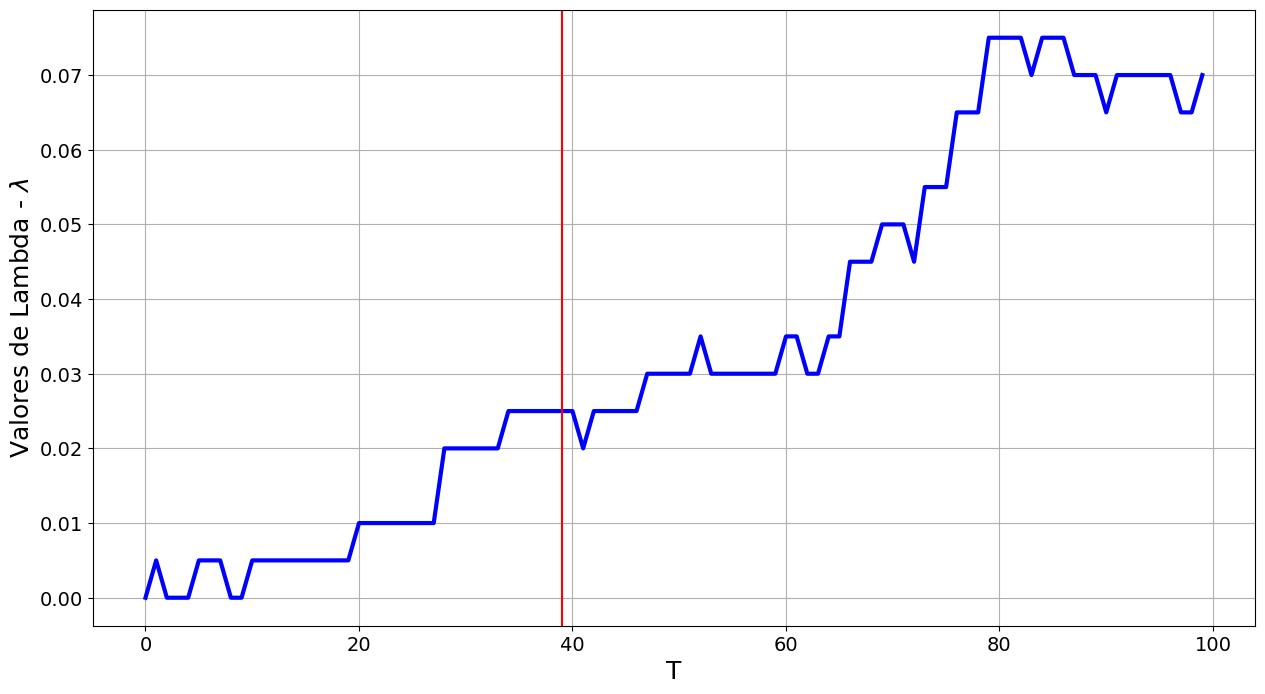

In [15]:
lista_lambda=[]
for i in (np.argmin(rms_K_val, axis=1)):
    A=np.arange(0,1,0.005)
    lista_lambda.append(A[i])
    
plt.figure(figsize=(15,8))
plt.plot(lista_lambda ,color="blue", linewidth=3)
plt.axvline(np.argmin(matriz_min)+1, color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.ylabel("Valores de Lambda - $\lambda$", fontsize=18)
plt.xlabel("T", fontsize=18)

### 3.4 Determinando os valores dos parâmetros <em> w </em> (pesos) e comparativo com os dados de teste

<font size=4.5>

<p style='text-align: justify;'>
Com ambos os valores de $\lambda$ e T em mãos levantou-se os valores do vetor de parâmetros w junto ao conjunto de treinamento como um todo (treinamento + validação). A partir dos valores de <em> w </em>, foi realizado o comparativo entre os dados de teste e aqueles obtidos pelo modelo. Conforme pode ser visto na Figura abaixo e a exemplo da primeira parte do exercício, o modelo de estimação conseguiu compreender as sazonalidades presentes nos dados de testes. 
</p>

Text(0, 0.5, 'Monthly Mean Total Sunspot Number')

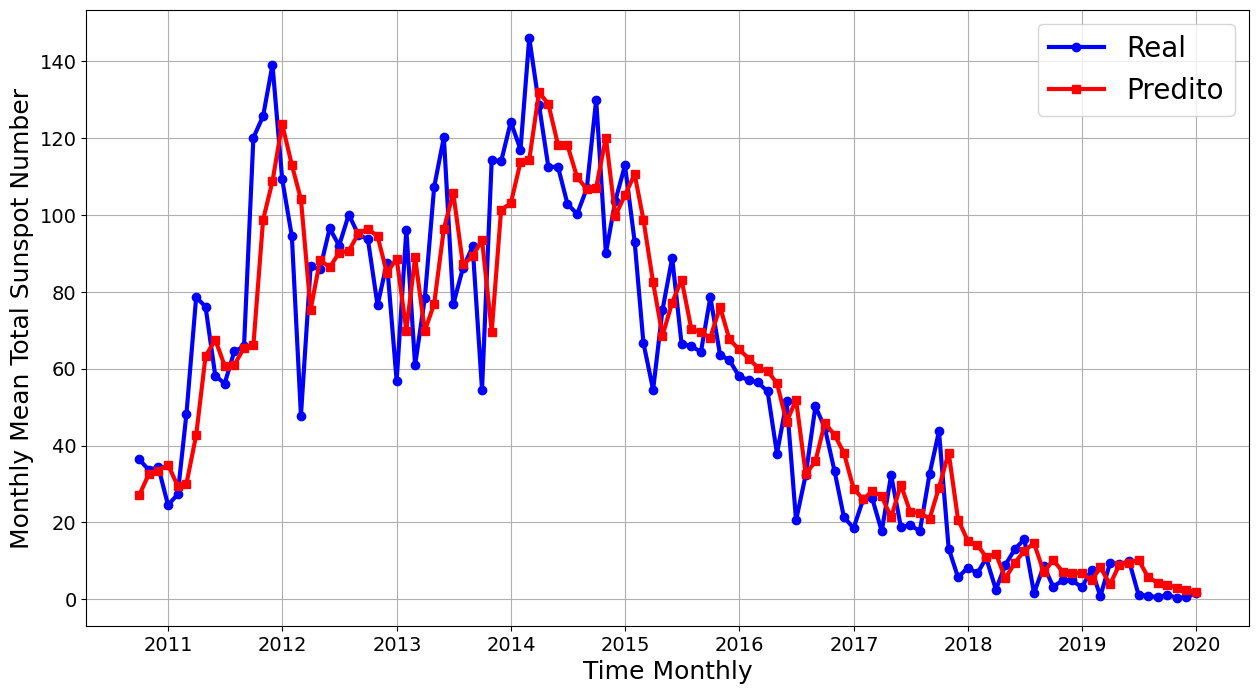

In [16]:
T_otm=np.argmin(matriz_min)+1
lambda_otm=lista_lambda[T_otm-1]

NL_train_data = final_X_train_data[:,0:T_otm]
vetor_bias=np.ones((len(NL_train_data),1))
NL_train_data = np.concatenate((vetor_bias, NL_train_data), axis=1)

w_train = normal_equation (NL_train_data,Y_train_data_norm,lambda_otm)

y_hat_train=np.dot(NL_train_data,w_train)
y_hat_desnorm_train = inver_norm(y_hat_train,min_data,data_interval)
NL_Y_train_desnorm=inver_norm(Y_train_data_norm,min_data,data_interval)


NL_test_data = final_X_test_data[:,0:T_otm]

vetor_bias=np.ones((len(NL_test_data),1))
NL_test_data = np.concatenate((vetor_bias, NL_test_data), axis=1) 

y_hat_teste=np.dot(NL_test_data,w_train)

y_hat_teste_desnorm = inver_norm(y_hat_teste, min_data, data_interval)
Y_test_data_desnorm = inver_norm(Y_test_data_norm, min_data, data_interval)


new_df = df[df['Date']>=df['Date'].max()-pd.DateOffset(months=120-8-1)]

fig=plt.figure(figsize=(15,8))
plt.plot(new_df['Date'],Y_test_data_desnorm ,color="blue", label="Real", linewidth=3, marker="o")
plt.plot(new_df['Date'],y_hat_teste_desnorm, color="red", label="Predito", linewidth=3, marker="s")
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel("Time Monthly", fontsize=18)
plt.ylabel("Monthly Mean Total Sunspot Number",fontsize=18)
